In [1]:
%load_ext autoreload
%autoreload 2

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loader" data-toc-modified-id="Data-loader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loader</a></span></li></ul></div>

# Подключение библиотек

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

# Download and load the validation split of COCO-2017
fo_dataset = foz.load_zoo_dataset("coco-2017", split="validation",
                               dataset_dir='/mnt/heap')

Found annotations at '/mnt/heap/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [22.2s elapsed, 0s remaining, 249.0 samples/s]      
Dataset 'coco-2017-validation' created


session = fo.launch_app(dataset)

In [2]:
fo_dataset.compute_metadata()

## Data set

In [3]:
import torch
import fiftyone.utils.coco as fouc
from viewer import Viewer
from PIL import Image

In [4]:
viewer = Viewer()

In [5]:
class FiftyOneTorchDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        fiftyone_dataset,
        transforms=None,
        gt_field="ground_truth",
        classes=None,
    ):
        self.samples = fiftyone_dataset
        self.transforms = transforms
        self.gt_field = gt_field

        self.img_paths = self.samples.values("filepath")

        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = self.samples.distinct(
                "%s.detections.label" % gt_field
            )

        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]
        metadata = sample.metadata
        img = Image.open(img_path).convert("RGB")

        boxes = []
        detections = sample[self.gt_field].detections
        img_has_person = 0
        for det in detections:
            if det.label != 'person':
                continue
            
            category_id = self.labels_map_rev[det.label]
            coco_obj = fouc.COCOObject.from_detection(
                det, metadata, category_id=category_id,
            )
            x, y, w, h = coco_obj.bbox
            
            boxes.append([x/metadata['width'], 
                          y/metadata['height'], 
                          (x + w)/metadata['width'], 
                          (y + h)/metadata['height']])
            
            img_has_person = 1

        target = {}
        target['img_width'] = metadata['width']
        target['img_height'] = metadata['height']
       
        target["box"] = []
        if img_has_person:
            box = None
            if len(boxes) > 1:
                box = sorted(boxes)[0]
            else:
                box = boxes[0]
            target["box"] = torch.as_tensor(box, dtype=torch.float32)        
            
        target["img_has_person"] = img_has_person
        target["img_path"] = img_path

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.img_paths)

    def get_classes(self):
        return self.classes

In [6]:
from fiftyone import ViewField as F

person_list = ["person"]
person_view = fo_dataset.filter_labels("ground_truth",
        F("label").is_in(person_list)).match(F("ground_truth.detections").length() == 1)
print(len(person_view))

1045


## Data loader

In [7]:
import torchvision.transforms as T

img_size = (256, 256)
train_transforms = T.Compose([T.Resize(img_size),
                              T.ToTensor()])
test_transforms = T.Compose([T.Resize(img_size),
                             T.ToTensor()])

In [8]:
# split the dataset in train and test set
train_view = person_view.take(len(person_view) * 0.75, seed=51)
test_view = person_view.exclude([s.id for s in train_view])

In [9]:
torch_dataset = FiftyOneTorchDataset(train_view, train_transforms,
        classes=person_list)
torch_dataset_test = FiftyOneTorchDataset(test_view, test_transforms, 
        classes=person_list)

In [10]:
len(torch_dataset)

783

In [11]:
len(torch_dataset_test)

262

In [12]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=64)
    
data_loader_test = torch.utils.data.DataLoader(
        torch_dataset_test, batch_size=64, shuffle=False)

# Train loop

In [13]:
from itertools import product
from pytorch_helper import PyTorchHelper

In [14]:
loss_function_xy = torch.nn.MSELoss()
loss_function_bce = torch.nn.CrossEntropyLoss()

In [15]:
from pytorch_helper import PyTorchHelper

def find_hyperparameters(config):
    learning_rates = [1e-1]
    anneal_coeff = 0.2
    anneal_epochs = [10]
    regs = config['regs']
    optimizers = config['optimizers']

    batch_size = 64
    epoch_num = 20

    run_record = {} 
    
    helper = PyTorchHelper(8,  None)

    lenet_model = None
    val_loss = 8
    loss_history = None
    for lr, reg, anneal_epoch, optimizer in product(learning_rates, regs, anneal_epochs, optimizers):
        lenet_model = config['model']() # base_lenet()

        loss = None

        optimizer = optimizer(lenet_model.parameters(), lr=lr, weight_decay=reg)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epoch, gamma=anneal_coeff)

        lenet_model, loss_history, val_loss = helper.train_model(config['model_name'],lenet_model, data_loader, data_loader_test, loss, optimizer, epoch_num, scheduler)

    return lenet_model, loss_history, val_loss

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.models import resnet18

In [17]:
def net():
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(in_features=512, out_features=5)
    return model

In [18]:
config = {
    'regs': [0.001],
    'optimizers': [optim.Adam],
    'model': net,
    'model_name': 'best_lenet'    
}

In [19]:
from resource_monitor import ResourceMonitor
resourceMonitor = ResourceMonitor()

In [20]:
resourceMonitor.print_statistics('MB')

memory_allocated: 0.0
max_memory_allocated: 0.0
memory_reserved: 0.0
max_memory_reserved: 0.0


In [21]:
model, train_loss_history, val_loss_history = find_hyperparameters(config)

Start train:
memory_allocated: 42.69677734375
max_memory_allocated: 42.69677734375
memory_reserved: 64.0
max_memory_reserved: 64.0
Epoch 0/19
----------
Step 0/13 Loss 1.8654165267944336
Step 1/13 Loss 28.10860252380371
Step 2/13 Loss 14.839417457580566
Step 3/13 Loss 8.8971586227417
Step 4/13 Loss 4.261048316955566
Step 5/13 Loss 3.053712844848633
Step 6/13 Loss 1.7522205114364624
Step 7/13 Loss 3.184950828552246
Step 8/13 Loss 1.9939509630203247
Step 9/13 Loss 1.3691078424453735
Step 10/13 Loss 0.8420224785804749
Step 11/13 Loss 0.8266505002975464
Step 12/13 Loss 0.7776943445205688
Average loss train: 5.980997
Average loss test: 191878.890625
memory_allocated: 174.14208984375
max_memory_allocated: 2031.17724609375
memory_reserved: 2744.0
max_memory_reserved: 2744.0
Epoch 1/19
----------
Step 0/13 Loss 0.6463892459869385
Step 1/13 Loss 0.4219985902309418
Step 2/13 Loss 0.440621018409729
Step 3/13 Loss 0.49577057361602783
Step 4/13 Loss 0.4336312413215637
Step 5/13 Loss 0.4942846596240

In [22]:
from matplotlib import pyplot as plt

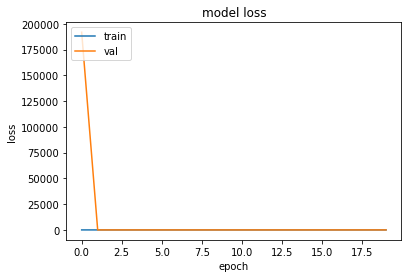

In [23]:
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [24]:
resourceMonitor.print_statistics('MB')

memory_allocated: 0.0
max_memory_allocated: 2031.177734375
memory_reserved: 2744.0
max_memory_reserved: 2744.0


In [25]:
===============================================

SyntaxError: invalid syntax (<ipython-input-25-4873ce4e3145>, line 1)

In [26]:
def predict(index):
    img, target = torch_dataset[index]
    pred = model(img.unsqueeze(0))[0]
    
    original_img = Image.open(target['img_path']).convert("RGB")
    viewer.print_prediction(original_img, target, pred)

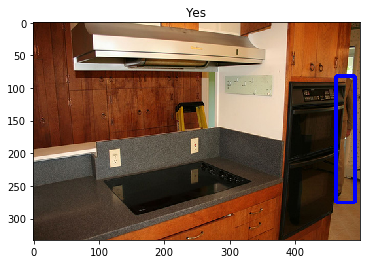

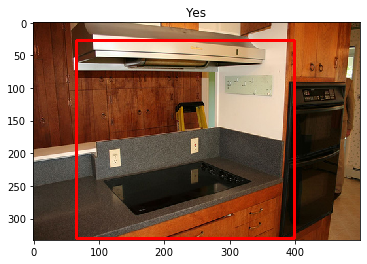

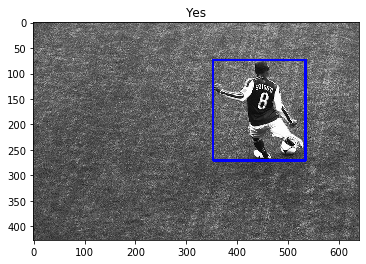

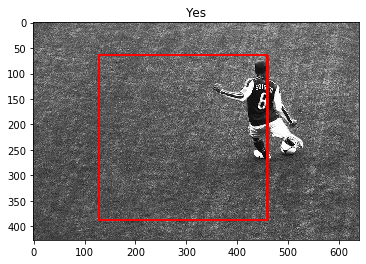

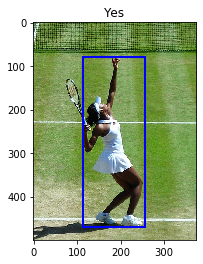

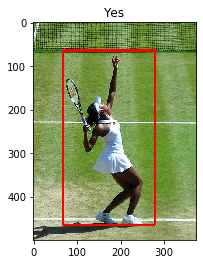

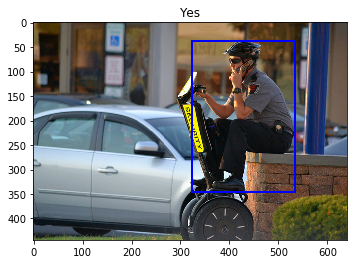

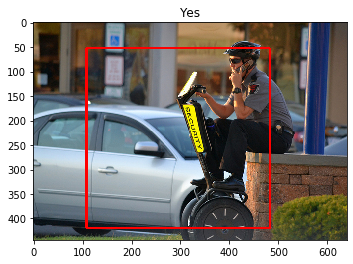

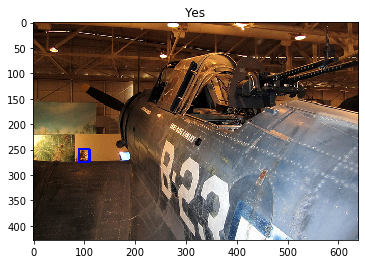

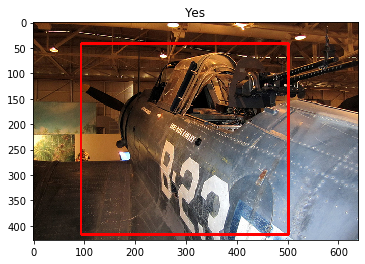

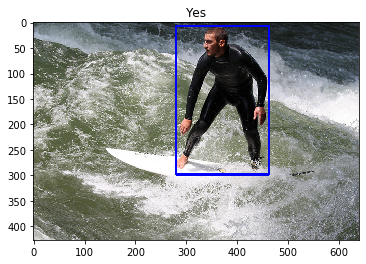

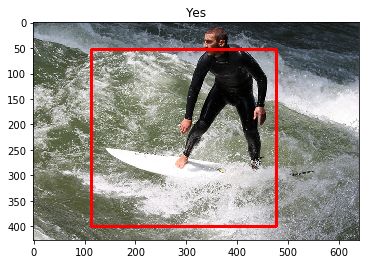

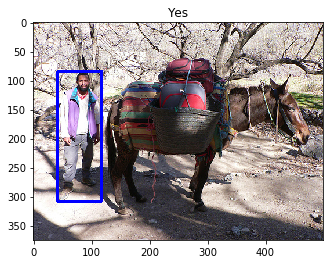

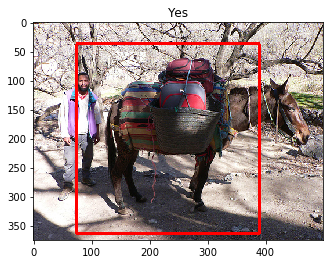

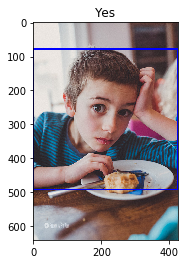

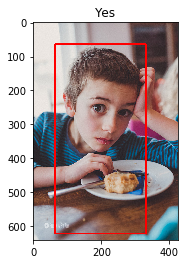

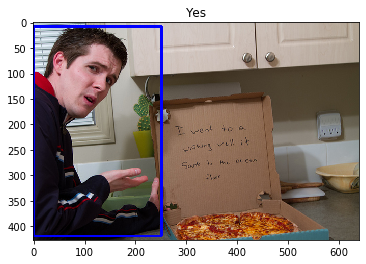

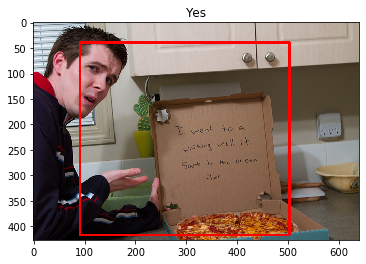

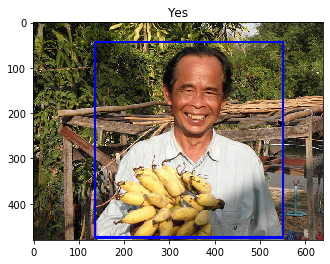

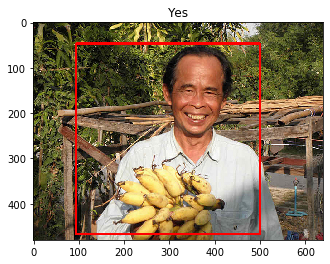

In [27]:
for i in range(160, 170):
    predict(i)

In [ ]:
===============================================

In [ ]:
===============================================

# Visualization

In [ ]:
import fiftyone as fo

def convert_torch_predictions(preds, det_id, s_id, w, h, classes):
    # Convert the outputs of the torch model into a FiftyOne Detections object
    dets = []
    #if preds[0] < 0.5:
     #   detections = fo.Detections(detections=dets)
      #  return detections, det_id
    
    # Parse prediction into FiftyOne Detection object
    x0,y0,x1,y1 = preds[1:]
    coco_obj = fouc.COCOObject(det_id, s_id, int(1), [x0, y0, x1-x0, y1-y0])
    det = coco_obj.to_detection((w,h), classes)
    dets.append(det)
    det_id += 1
        
    detections = fo.Detections(detections=dets)
        
    return detections, det_id

def add_detections(model, torch_dataset, view, field_name="predictions"):
    # Run inference on a dataset and add results to FiftyOne
    torch.set_num_threads(1)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    model.eval()
    model.to(device)
    image_paths = torch_dataset.img_paths
    classes = torch_dataset.classes
    det_id = 0
    
    with fo.ProgressBar() as pb:
        for img, targets in pb(torch_dataset):
            sample = view[targets["img_path"]]
            s_id = sample.id
            w = sample.metadata["width"]
            h = sample.metadata["height"]
            
            # Inference
            preds = model(img.unsqueeze(0).to(device))[0]
            
            detections, det_id = convert_torch_predictions(
                preds, 
                det_id, 
                s_id, 
                w, 
                h, 
                classes,
            )
            
            sample["predictions"] = detections
            sample.save()

In [ ]:
add_detections(model, torch_dataset_test, fo_dataset)

In [ ]:
session = fo.launch_app(fo_dataset)